<a href="https://colab.research.google.com/github/JulieWang417/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Julie_Wang_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

## Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [0]:
condition = ((df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
(df['SALE_PRICE']>100000) & (df['SALE_PRICE']<200000000))

df_fam= df[condition]

In [6]:
df_fam.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [7]:
df_fam.shape

(3232, 21)

In [8]:
df_fam['LAND_SQUARE_FEET'] = df_fam['LAND_SQUARE_FEET'].str.replace(",","")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
df_fam['LAND_SQUARE_FEET'] = pd.to_numeric(df_fam['LAND_SQUARE_FEET'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [10]:
df_fam['SALE_DATE']=pd.to_datetime(df_fam['SALE_DATE'])

train= df_fam[df_fam.SALE_DATE.dt.month < 4]
test= df_fam[df_fam.SALE_DATE.dt.month == 4]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
train.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                           int64
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [12]:
train.shape,test.shape

((2576, 21), (656, 21))

In [13]:
train['SALE_DATE'].dt.month.value_counts()

1    970
3    821
2    785
Name: SALE_DATE, dtype: int64

In [14]:
print(test['SALE_DATE'].dt.month.unique())

[4]


In [15]:
df_fam['LAND_SQUARE_FEET'].dtypes

dtype('int64')

In [16]:
df_fam.describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,3232.0,6820.242265,3.987840e+03,21.0,3848.75,6215.0,10062.5,16350.0
LOT,3232.0,76.495978,1.664000e+02,1.0,21.00,42.0,69.0,2780.0
EASE-MENT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP_CODE,3232.0,11021.084158,4.871971e+02,10009.0,10461.00,11234.0,11413.0,11697.0
RESIDENTIAL_UNITS,3232.0,0.987933,1.119996e-01,0.0,1.00,1.0,1.0,2.0
COMMERCIAL_UNITS,3232.0,0.018255,1.384387e-01,0.0,0.00,0.0,0.0,2.0
TOTAL_UNITS,3232.0,1.006188,1.793039e-01,0.0,1.00,1.0,1.0,3.0
LAND_SQUARE_FEET,3232.0,3131.556931,1.852687e+03,0.0,2000.00,2539.0,4000.0,18906.0
GROSS_SQUARE_FEET,3232.0,1523.759901,7.429690e+02,0.0,1150.00,1368.0,1727.0,11224.0
YEAR_BUILT,3232.0,1943.176671,2.699033e+01,1890.0,1925.00,1935.5,1955.0,2018.0


In [17]:
df_fam.describe(exclude='number').T

,count,unique,top,freq,first,last
BOROUGH,3232,5,4,1591,NaT,NaT
NEIGHBORHOOD,3232,9,OTHER,3026,NaT,NaT
BUILDING_CLASS_CATEGORY,3232,1,01 ONE FAMILY DWELLINGS,3232,NaT,NaT
TAX_CLASS_AT_PRESENT,3232,2,1,3192,NaT,NaT
BUILDING_CLASS_AT_PRESENT,3232,14,A1,1203,NaT,NaT
ADDRESS,3232,3215,118-20 202ND STREET,2,NaT,NaT
APARTMENT_NUMBER,2,2,RP.,1,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,3232,12,A1,1204,NaT,NaT
SALE_DATE,3232,91,2019-01-31 00:00:00,80,2019-01-01,2019-04-30


In [18]:
df_fam['TAX_CLASS_AT_PRESENT'].value_counts(dropna = True)

1     3192
1D      40
Name: TAX_CLASS_AT_PRESENT, dtype: int64

In [19]:
df_fam['BOROUGH'].value_counts(dropna = True)

4    1591
5     739
3     573
2     299
1      30
Name: BOROUGH, dtype: int64

In [20]:
df_fam['NEIGHBORHOOD'].value_counts(dropna = True)

OTHER                      3026
FLUSHING-NORTH               97
EAST NEW YORK                31
FOREST HILLS                 26
BOROUGH PARK                 19
ASTORIA                      14
BEDFORD STUYVESANT           10
UPPER EAST SIDE (59-79)       7
UPPER EAST SIDE (79-96)       2
Name: NEIGHBORHOOD, dtype: int64

In [0]:
target = 'SALE_PRICE'
number_column = train.select_dtypes(include='number').columns.drop(target).tolist()
categorical_column = train.select_dtypes(exclude='number').columns.tolist()
low_cardinality_catg = [col for col in categorical_column
                               if train[col].nunique() <= 50]

features=number_column + low_cardinality_catg

In [0]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [23]:
X_train

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,APARTMENT_NUMBER,BUILDING_CLASS_AT_TIME_OF_SALE
44,5495,801,NaN,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,3,OTHER,01 ONE FAMILY DWELLINGS,1,A9,NaN,A9
61,7918,72,NaN,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,NaN,A1
78,4210,19,NaN,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,2,OTHER,01 ONE FAMILY DWELLINGS,1,A1,NaN,A1
108,5212,69,NaN,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,3,OTHER,01 ONE FAMILY DWELLINGS,1,A1,NaN,A1
111,7930,121,NaN,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,3,OTHER,01 ONE FAMILY DWELLINGS,1,A5,NaN,A5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,4081,44,NaN,10306.0,1.0,0.0,1.0,2400,921.0,1950.0,1,5,OTHER,01 ONE FAMILY DWELLINGS,1,A2,NaN,A2
18130,2373,201,NaN,10314.0,1.0,0.0,1.0,2450,2128.0,1980.0,1,5,OTHER,01 ONE FAMILY DWELLINGS,1,A5,NaN,A5
18132,1132,42,NaN,10302.0,1.0,0.0,1.0,4361,1807.0,2018.0,1,5,OTHER,01 ONE FAMILY DWELLINGS,1,A1,NaN,A1
18134,3395,37,NaN,10305.0,1.0,0.0,1.0,6000,621.0,1930.0,1,5,OTHER,01 ONE FAMILY DWELLINGS,1,A2,NaN,A2


In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)

In [0]:
X_test = encoder.transform(X_test)

In [26]:
X_train

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_UPPER EAST SIDE (79-96),BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_A7,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,APARTMENT_NUMBER_nan,APARTMENT_NUMBER_RP.,APARTMENT_NUMBER_8,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,5495,801,NaN,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
61,7918,72,NaN,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
78,4210,19,NaN,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
108,5212,69,NaN,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
111,7930,121,NaN,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,4081,44,NaN,10306.0,1.0,0.0,1.0,2400,921.0,1950.0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
18130,2373,201,NaN,10314.0,1.0,0.0,1.0,2450,2128.0,1980.0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
18132,1132,42,NaN,10302.0,1.0,0.0,1.0,4361,1807.0,2018.0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
18134,3395,37,NaN,10305.0,1.0,0.0,1.0,6000,621.0,1930.0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Do one-hot encoding of categorical features.

In [0]:
# Encoding 
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test= encoder.transform(X_test)

In [0]:
X_train.drop(['EASE-MENT'],inplace=True,axis=1)

In [0]:
X_test.drop(['EASE-MENT'],inplace=True,axis=1)

## Do feature selection with SelectKBest.

In [34]:
from sklearn.feature_selection import f_regression, SelectKBest
selector= SelectKBest(score_func=f_regression,k=15)

X_train_selected= pd.DataFrame(selector.fit_transform(X_train,y_train), columns=X_train.columns[selector.get_support()])
X_test_selected= pd.DataFrame(selector.transform(X_test), columns=X_test.columns[selector.get_support()])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

1 features
Test MAE: $290,855 

2 features
Test MAE: $288,471 

3 features
Test MAE: $255,484 

4 features
Test MAE: $260,289 

5 features
Test MAE: $258,212 

6 features
Test MAE: $258,212 

7 features
Test MAE: $253,793 

8 features
Test MAE: $241,563 

9 features
Test MAE: $244,664 

10 features
Test MAE: $242,496 

11 features
Test MAE: $243,042 

12 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $243,669 

13 features
Test MAE: $240,242 

14 features
Test MAE: $241,032 

15 features
Test MAE: $241,184 

16 features
Test MAE: $241,051 

17 features
Test MAE: $239,593 

18 features
Test MAE: $239,593 

19 features
Test MAE: $240,136 

20 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $240,139 

21 features
Test MAE: $242,432 

22 features
Test MAE: $242,413 

23 features
Test MAE: $242,402 

24 features
Test MAE: $238,119 

25 features
Test MAE: $238,679 

26 features
Test MAE: $231,386 

27 features
Test MAE: $231,386 

28 features
Test MAE: $232,051 

29 features
Test MAE: $232,054 

30 features
Test MAE: $231,957 

31 features
Test MAE: $231,483 

32 features
Test MAE: $231,031 

33 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $231,252 

34 features
Test MAE: $231,117 

35 features
Test MAE: $231,041 

36 features
Test MAE: $230,992 

37 features
Test MAE: $231,199 

38 features
Test MAE: $231,199 

39 features
Test MAE: $231,275 

40 features
Test MAE: $231,291 

41 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $231,954 

42 features
Test MAE: $228,431 

43 features
Test MAE: $229,223 

44 features
Test MAE: $229,220 

45 features
Test MAE: $226,803 

46 features
Test MAE: $226,761 

47 features
Test MAE: $226,761 

48 features
Test MAE: $226,104 

49 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $226,104 

50 features
Test MAE: $226,037 

51 features
Test MAE: $226,062 

52 features
Test MAE: $226,062 

53 features
Test MAE: $226,097 

54 features
Test MAE: $226,363 

55 features
Test MAE: $226,363 

56 features
Test MAE: $226,363 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


## Feature Scaling

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(True, True)

In [0]:
# Feature Scaling 
X_train_scaler= pd.DataFrame(scaler.fit_transform(X_train_selected,y_train), columns=X_train_selected.columns)
X_test_scaler= pd.DataFrame(scaler.transform(X_test_selected), columns=X_test_selected.columns)

In [36]:
X_train_selected

,BLOCK,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),BUILDING_CLASS_AT_PRESENT_A7,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4
0,5495.0,0.0,1.0,1325.0,1930.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7918.0,0.0,1.0,2001.0,1940.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4210.0,0.0,1.0,2043.0,1925.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5212.0,0.0,1.0,2680.0,1899.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7930.0,0.0,1.0,1872.0,1940.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,4081.0,0.0,1.0,921.0,1950.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2572,2373.0,0.0,1.0,2128.0,1980.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2573,1132.0,0.0,1.0,1807.0,2018.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2574,3395.0,0.0,1.0,621.0,1930.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_train_scaler

,BLOCK,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),BUILDING_CLASS_AT_PRESENT_A7,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4
0,-0.291843,-0.132292,-0.03679,-0.268909,-0.518488,-0.588707,-0.092811,0.256484,-0.048318,-0.019707,-0.019707,-0.117363,-0.019707,-0.131824,-0.117363
1,0.314517,-0.132292,-0.03679,0.629563,-0.153324,-0.588707,-0.092811,0.256484,-0.048318,-0.019707,-0.019707,-0.117363,-0.019707,-0.131824,-0.117363
2,-0.613417,-0.132292,-0.03679,0.685386,-0.701071,-0.588707,-0.092811,0.256484,-0.048318,-0.019707,-0.019707,-0.117363,-0.019707,-0.131824,-0.117363
3,-0.362664,-0.132292,-0.03679,1.532024,-1.650499,-0.588707,-0.092811,0.256484,-0.048318,-0.019707,-0.019707,-0.117363,-0.019707,-0.131824,-0.117363
4,0.317520,-0.132292,-0.03679,0.458109,-0.153324,-0.588707,-0.092811,0.256484,-0.048318,-0.019707,-0.019707,-0.117363,-0.019707,-0.131824,-0.117363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,-0.645699,-0.132292,-0.03679,-0.805866,0.211841,1.698638,-0.092811,0.256484,-0.048318,-0.019707,-0.019707,-0.117363,-0.019707,-0.131824,-0.117363
2572,-1.073130,-0.132292,-0.03679,0.798359,1.307335,1.698638,-0.092811,0.256484,-0.048318,-0.019707,-0.019707,-0.117363,-0.019707,-0.131824,-0.117363
2573,-1.383692,-0.132292,-0.03679,0.371718,2.694960,1.698638,-0.092811,0.256484,-0.048318,-0.019707,-0.019707,-0.117363,-0.019707,-0.131824,-0.117363
2574,-0.817372,-0.132292,-0.03679,-1.204597,-0.518488,1.698638,-0.092811,0.256484,-0.048318,-0.019707,-0.019707,-0.117363,-0.019707,-0.131824,-0.117363


## Fit a ridge regression model with multiple features.

In [0]:
# Ridge Regression
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt

In [0]:
alphas = [0.001, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0]

In [51]:
from sklearn.linear_model import RidgeCV
Selector= SelectKBest(score_func=f_regression,k=8)
X_train_selected_R = selector.fit_transform(X_train_scaler, y_train)
X_test_selected_R = selector.transform(X_test_scaler)

ridge_cv = RidgeCV(alphas=alphas,normalize=True)
model_cv = ridge_cv.fit(X_train_selected_R,y_train)
y_ridge_pred= ridge_cv.predict(X_test_selected_R)
mae= mean_absolute_error(y_test,y_ridge_pred)
print(f'Test MAE: ${mae:,.0f} \n')


Test MAE: $237,614 



In [52]:
model_cv.alpha_

0.05

In [54]:
ridge_cv.score(X_train_selected_R,y_train)

0.7787025033383721

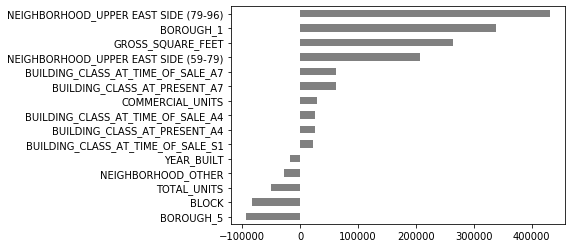

In [56]:
%matplotlib inline
coefficients = pd.Series(ridge_cv.coef_, X_train_selected.columns)
coefficients.sort_values().plot.barh(color='grey');

In [57]:
print(coefficients.to_string())

BLOCK                                   -82654.904744
COMMERCIAL_UNITS                         29735.041319
TOTAL_UNITS                             -50723.522018
GROSS_SQUARE_FEET                       263974.397330
YEAR_BUILT                              -17225.009975
BOROUGH_5                               -93978.595552
BOROUGH_1                               338340.169603
NEIGHBORHOOD_OTHER                      -27907.936508
NEIGHBORHOOD_UPPER EAST SIDE (59-79)    207186.707324
NEIGHBORHOOD_UPPER EAST SIDE (79-96)    431700.751120
BUILDING_CLASS_AT_PRESENT_A7             62456.746325
BUILDING_CLASS_AT_PRESENT_A4             26041.957382
BUILDING_CLASS_AT_TIME_OF_SALE_A7        62456.746325
BUILDING_CLASS_AT_TIME_OF_SALE_S1        21473.710847
BUILDING_CLASS_AT_TIME_OF_SALE_A4        26041.957382
